In [1]:
!pip install ics

In [12]:
import csv
import os
from ics import Calendar, Event
from datetime import datetime, timedelta

def time_str_to_obj(time_str):
    time_str = str(time_str)  # Converts time_str to a string representation
    try:
        return datetime.strptime(time_str, "%I:%M %p")  # Try 12-hour format first
    except ValueError:
        try:
            return datetime.strptime(time_str, "%H:%M")  # Try 24-hour format if 12-hour fails
        except ValueError:
            print(f"Error parsing time string: {time_str}")  # Log the problematic string
            raise

def time_obj_to_str(time_obj):
    return time_obj.strftime('%H:%M')  # Format as needed

club_classes_together = True  # Use True instead of true
use_8AM_9AM_slot = True
use_6PM_7PM_slot = True  # Added missing variable declaration

def ensure_consecutive_classes(timetable):
    updated_timetable = []
    last_end_time = None
    for entry in timetable:
        start_time = time_str_to_obj(entry['Start Time'])
        duration = timedelta(hours=int(entry['Duration']))
        end_time = start_time + duration

        if last_end_time and start_time != last_end_time:  # Check if class is consecutive
            start_time = last_end_time
            end_time = start_time + duration
            entry['Start Time'] = time_obj_to_str(start_time)

        updated_timetable.append(entry)
        last_end_time = end_time  # Update the end time for the next class

    return updated_timetable

def process_timetable(file_path):
    if not os.path.exists(file_path):
        print(f"Timetable file {file_path} not found!")
        return {}

    timetables = {branch: [] for branch in BRANCHES.values()}
    venue_schedule = {}  # Dictionary to track venue usage

    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            course = row.get('Course Name')
            instructor = row.get('Instructor Name')
            course_type = row.get('Type')
            location = row.get('Location')
            start_time = row.get('Start Time')
            day = row.get('Day')
            students = row.get('Students')
            duration = row.get('Duration')

            if all([course, instructor, course_type, location, start_time, day, students, duration]):
                students = int(students)
                check_capacity(location, students)

                if len(course) >= 4:
                    prefix = course[:3]
                    if prefix in BRANCHES:
                        if not venue_clash(venue_schedule, location, day, start_time, duration):
                            timetables[BRANCHES[prefix]].append(row)
                            register_venue_usage(venue_schedule, location, day, start_time, duration)
                        else:
                            print(f"Venue clash for {course} in {location} at {start_time} on {day}")
                    else:
                        print(f"Prefix {prefix} not found in BRANCHES")
            else:
                print(f"Incomplete row found: {row}")

    timetables = apply_preferences_and_sort(timetables, venue_schedule)

    print("Final Timetable:")
    for branch, timetable in timetables.items():
        print(f"\nBranch: {branch}")
        for entry in timetable:
            print(entry)

    return timetables

def apply_preferences_and_sort(timetables, venue_schedule):
    for branch, timetable in timetables.items():
        if timetable:
            timetable.sort(key=lambda x: time_str_to_obj(x['Start Time']))

            if club_classes_together:
                timetable = ensure_consecutive_classes(timetable)

            if use_8AM_9AM_slot:
                duration = timedelta(hours=1)  # Set the duration for this slot
                assign_time_slot(timetable, '8:00 AM', venue_schedule, duration)

            if use_6PM_7PM_slot:
                duration = timedelta(hours=1)  # Set the duration for this slot
                assign_time_slot(timetable, '18:00', venue_schedule, duration)  # Use 24-hour format

    return timetables

def assign_time_slot(timetable, slot_start, venue_schedule, duration):
    slot_start_obj = time_str_to_obj(slot_start)
    slot_end_obj = slot_start_obj + duration  # Calculate end time based on the slot start and duration

    for entry in timetable:
        start_time = entry['Start Time']
        location = entry['Location']
        day = entry['Day']

        start_time_obj = time_str_to_obj(start_time)
        entry_duration = timedelta(hours=int(entry['Duration']))  # Assume duration is in hours

        end_time_obj = start_time_obj + entry_duration

        if start_time_obj >= slot_start_obj and end_time_obj <= slot_end_obj and not venue_clash(venue_schedule, location, day, slot_start, entry_duration):
            entry['Start Time'] = slot_start
            entry['End Time'] = (slot_start_obj + entry_duration).strftime('%I:%M')  # Update end time in desired format
            register_venue_usage(venue_schedule, location, day, slot_start, entry_duration)

from datetime import timedelta

def venue_clash(venue_schedule, location, day, start_time, duration):
    start_time_obj = time_str_to_obj(start_time)

    # Check if duration is a timedelta, then convert to hours
    if isinstance(duration, timedelta):
        duration_hours = duration.total_seconds() / 3600  # Convert to hours
    else:
        duration_hours = int(duration)  # Assuming duration is in hours

    duration_timedelta = timedelta(hours=duration_hours)  # Create timedelta
    end_time_obj = start_time_obj + duration_timedelta

    # Check if the location is scheduled on the given day
    if day not in venue_schedule or location not in venue_schedule[day]:
        return False  # No clash if the location isn't scheduled on this day

    # Retrieve scheduled events for the location on the specified day
    scheduled_events = venue_schedule[day][location]

    # Check for clashes with existing events
    for event in scheduled_events:
        event_start_time = event['start_time']  # Assuming event dict has a 'start_time' key
        event_duration = event['duration']  # Assuming event dict has a 'duration' key
        event_end_time = event_start_time + timedelta(hours=event_duration)

        # Check if the new event overlaps with the scheduled event
        if (start_time_obj < event_end_time) and (end_time_obj > event_start_time):
            return True  # There is a clash

    return False  # No clash found

def register_venue_usage(venue_schedule, location, day, start_time, duration):
    if location not in venue_schedule:
        venue_schedule[location] = []

    venue_schedule[location].append({
        'Day': day,
        'Start Time': start_time,
        'Duration': duration
    })

BRANCHES = {
    "CS4": "CS_fourth_year",
    "CS3": "CS_third_year",
    "EE3": "EE_third_year",
    "EE4": "EE_fourth_year",
    "ME1": "ME_first_year",
    "ME2": "ME_second_year",
    "ME3": "ME_third_year",
    "CE2": "CE_second_year",
    "CE3": "CE_third_year",
}

CSV_DIR = './tt-csv'
ICAL_DIR = './tt-ical'
VENUE_FILE = './venue.csv'
TT_FILE = './tt.csv'

os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(ICAL_DIR, exist_ok=True)

def load_venue_capacity(file_path):
    if not os.path.exists(file_path):
        print(f"Venue file {file_path} not found!")
        return {}

    venues = {}
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            venues[row['Venue Name']] = int(row['Max Capacity'])

    print(f"Loaded {len(venues)} venues.")
    return venues

venue_capacity = load_venue_capacity(VENUE_FILE)

def check_capacity(location, students):
    if location in venue_capacity and students > venue_capacity[location]:
        print(f"Warning: Venue {location} exceeded capacity ({students} > {venue_capacity[location]})")

timetables = process_timetable(TT_FILE)


Loaded 11 venues.
Final Timetable:

Branch: CS_fourth_year
{'Course Name': 'CS482', 'Instructor Name': 'Sanjoy Kumar Parida', 'Type': 'Lecture', 'Location': 'Classroom', 'Start Time': '8:00 AM', 'Day': 'Tuesday', 'Students': '60', 'Duration': '1', 'End Time': '09:00'}
{'Course Name': 'CS483', 'Instructor Name': 'Sanjoy Kumar Parida', 'Type': 'Lecture', 'Location': 'R-109', 'Start Time': '09:00', 'Day': 'Monday', 'Students': '60', 'Duration': '1'}
{'Course Name': 'CS483', 'Instructor Name': 'Sanjoy Kumar Parida', 'Type': 'Tutorial', 'Location': 'Classroom', 'Start Time': '10:00', 'Day': 'Tuesday', 'Students': '30', 'Duration': '1'}
{'Course Name': 'CS483', 'Instructor Name': 'Sanjoy Kumar Parida', 'Type': 'Lab', 'Location': 'Laboratory', 'Start Time': '11:00', 'Day': 'Friday', 'Students': '30', 'Duration': '2'}

Branch: CS_third_year
{'Course Name': 'CS384', 'Instructor Name': 'Anjali Verma', 'Type': 'Lecture', 'Location': 'Lab A', 'Start Time': '09:00', 'Day': 'Thursday', 'Students': '

Saved batch 1 for CS_fourth_year to tt-csv/timetable_batch_CS_fourth_year_1.csv
Saved batch 2 for CS_fourth_year to tt-csv/timetable_batch_CS_fourth_year_2.csv
Saved batch 3 for CS_fourth_year to tt-csv/timetable_batch_CS_fourth_year_3.csv
Saved batch 4 for CS_fourth_year to tt-csv/timetable_batch_CS_fourth_year_4.csv
Saved batch 1 for CS_third_year to tt-csv/timetable_batch_CS_third_year_1.csv
Saved batch 2 for CS_third_year to tt-csv/timetable_batch_CS_third_year_2.csv
Saved batch 3 for CS_third_year to tt-csv/timetable_batch_CS_third_year_3.csv
Saved batch 4 for CS_third_year to tt-csv/timetable_batch_CS_third_year_4.csv
Saved batch 5 for CS_third_year to tt-csv/timetable_batch_CS_third_year_5.csv
Saved batch 6 for CS_third_year to tt-csv/timetable_batch_CS_third_year_6.csv
Saved batch 7 for CS_third_year to tt-csv/timetable_batch_CS_third_year_7.csv
Saved batch 8 for CS_third_year to tt-csv/timetable_batch_CS_third_year_8.csv
Saved batch 1 for EE_fourth_year to tt-csv/timetable_bat

<ipython-input-27-4a5c0bf1ed62>:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(patches.Rectangle(


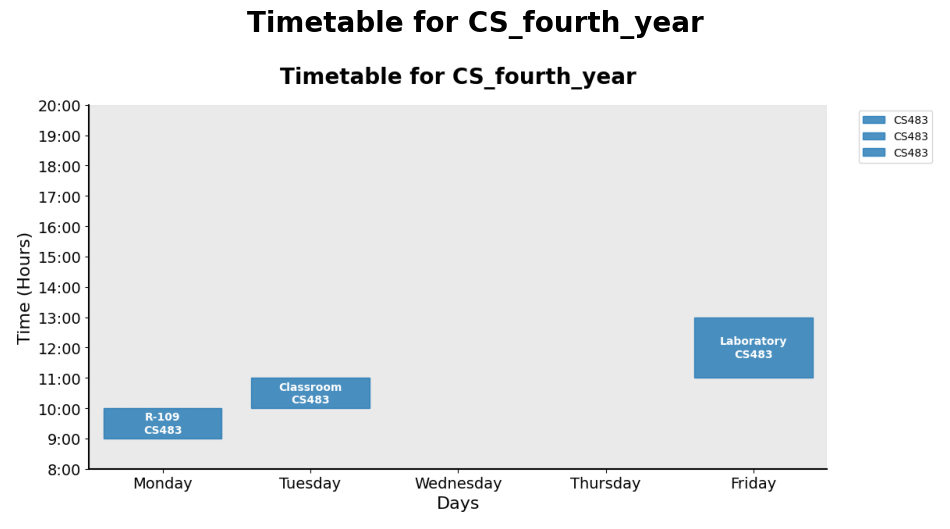

Saved and displayed timetable image for CS_fourth_year at /tt-image/timetable_CS_fourth_year.png


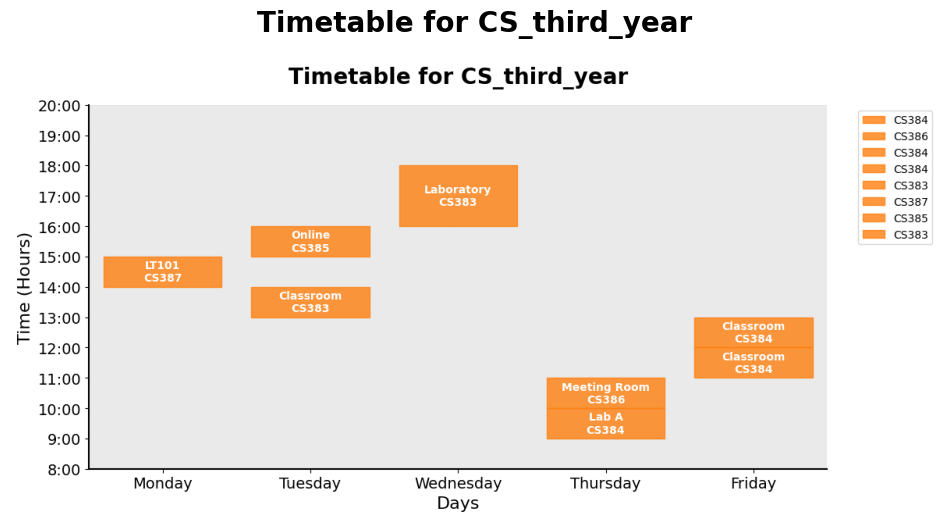

Saved and displayed timetable image for CS_third_year at /tt-image/timetable_CS_third_year.png


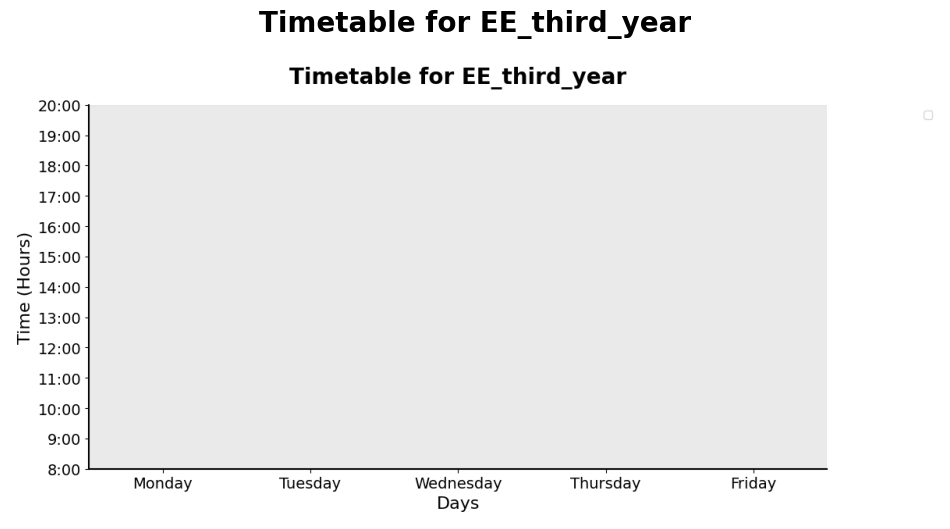

Saved and displayed timetable image for EE_third_year at /tt-image/timetable_EE_third_year.png


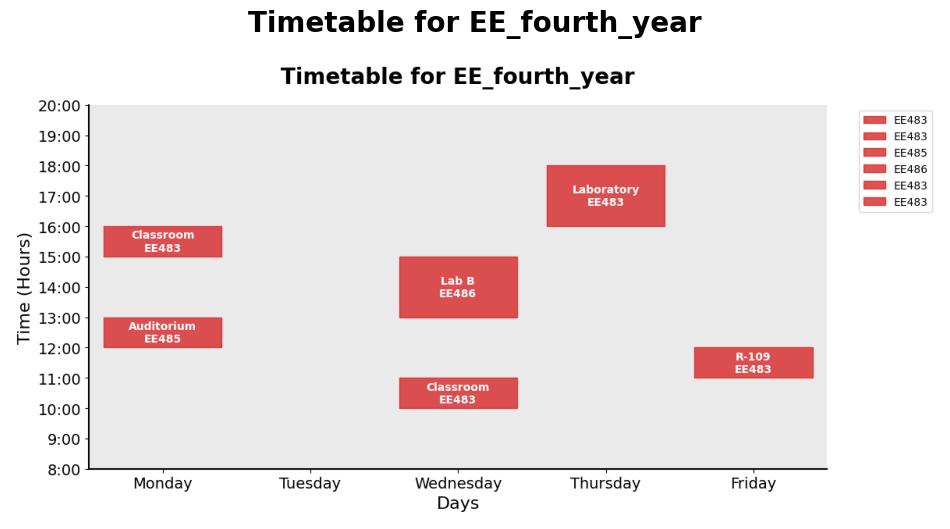

Saved and displayed timetable image for EE_fourth_year at /tt-image/timetable_EE_fourth_year.png
Error parsing time for entry {'Course Name': 'ME102', 'Instructor Name': 'Aditi Sharma', 'Type': 'Lecture', 'Location': 'Classroom', 'Start Time': '8:00 AM', 'Day': 'Monday', 'Students': '50', 'Duration': '1', 'End Time': '09:00'}: unconverted data remains:  AM


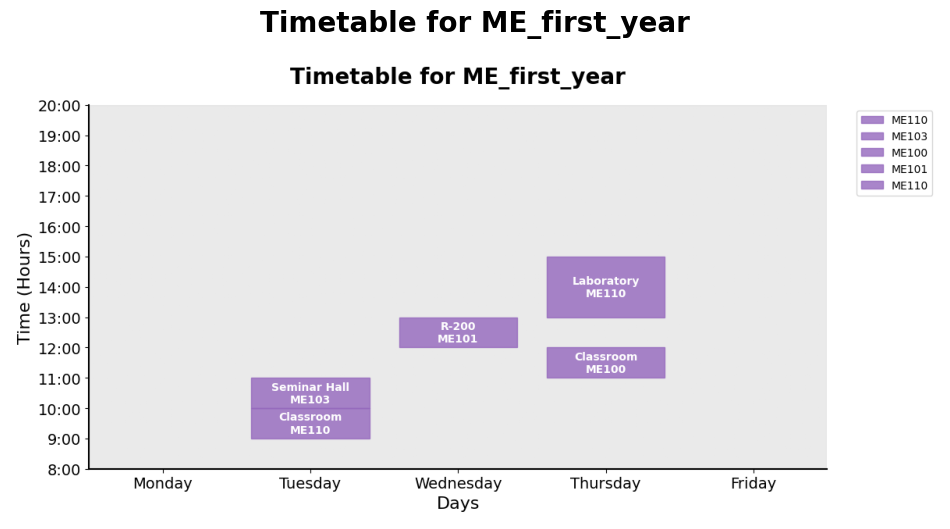

Saved and displayed timetable image for ME_first_year at /tt-image/timetable_ME_first_year.png


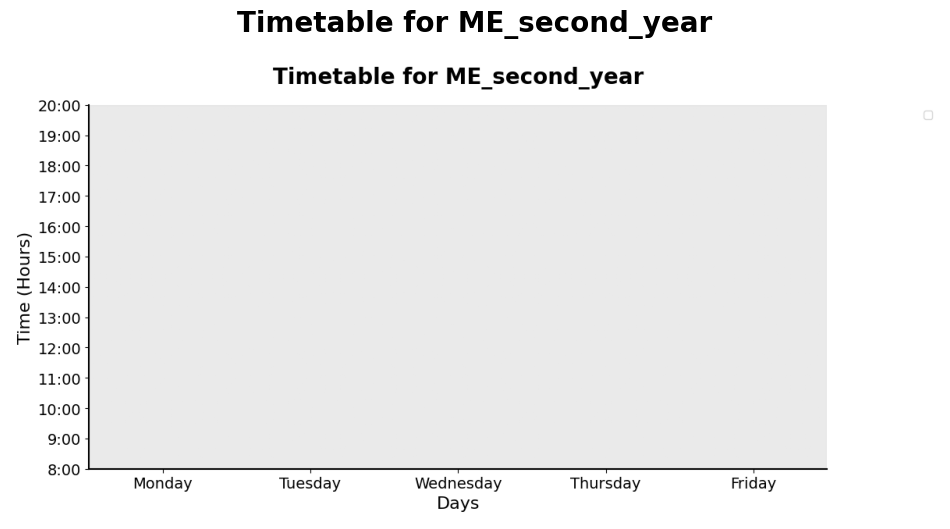

Saved and displayed timetable image for ME_second_year at /tt-image/timetable_ME_second_year.png


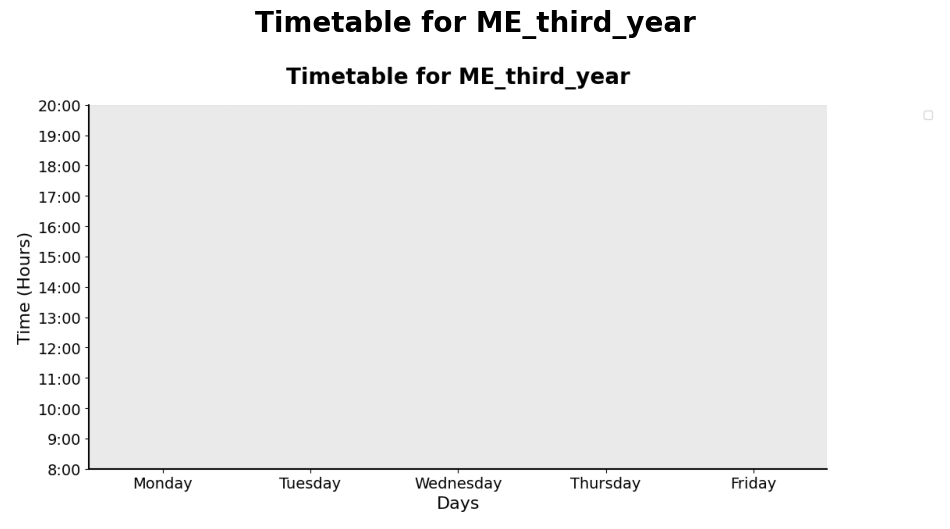

Saved and displayed timetable image for ME_third_year at /tt-image/timetable_ME_third_year.png


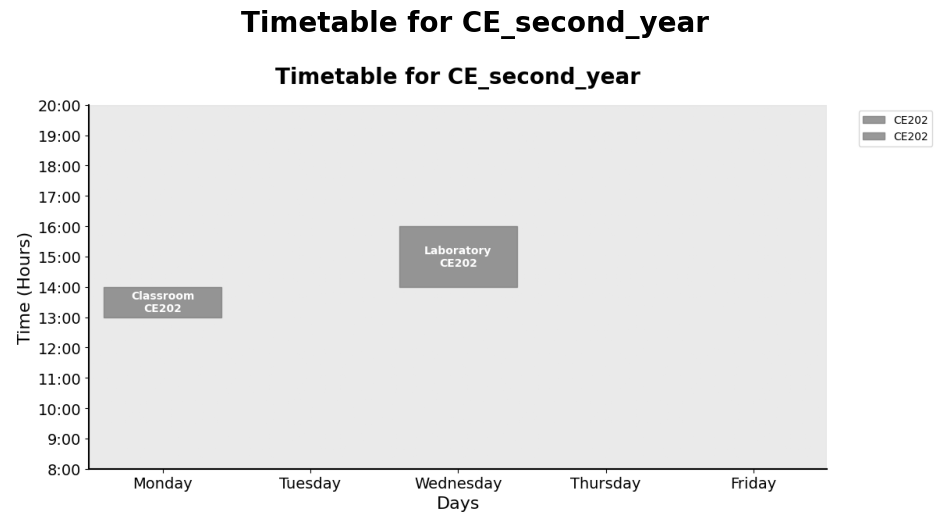

Saved and displayed timetable image for CE_second_year at /tt-image/timetable_CE_second_year.png


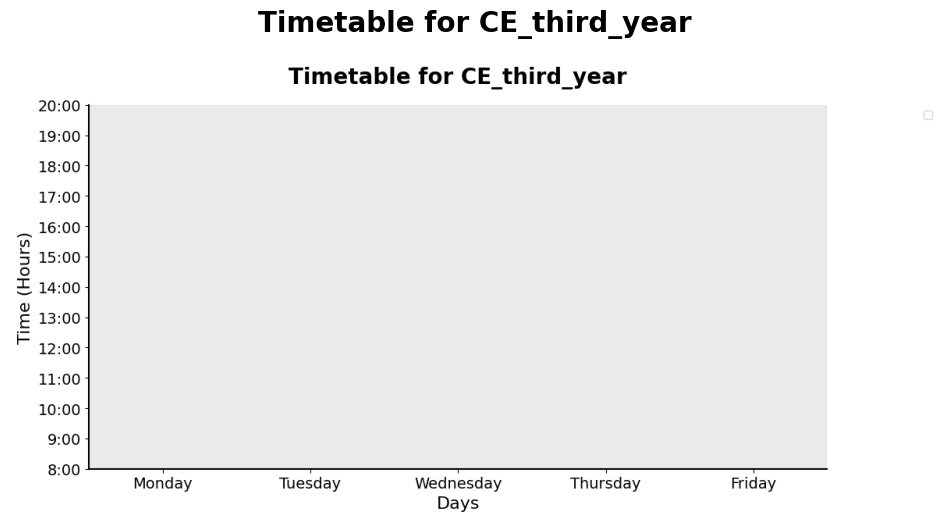

Saved and displayed timetable image for CE_third_year at /tt-image/timetable_CE_third_year.png


In [27]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from datetime import datetime, timedelta

# Ensure the output directory exists
output_dir = '/tt-image'
os.makedirs(output_dir, exist_ok=True)

def time_str_to_obj(time_str):
    """Convert time string to a datetime object in 24-hour format."""
    return datetime.strptime(time_str, '%H:%M')  # Expecting 24-hour format

def save_timetable_to_csv(timetables, batch_size=10, filename_prefix='timetable_batch'):
    """
    Saves timetable data to CSV files in batches.

    :param timetables: Dictionary containing timetable data.
    :param batch_size: Number of entries per CSV file.
    :param filename_prefix: Prefix for the output CSV files.
    """
    output_dir = 'tt-csv'  # Define the output directory
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    for branch, timetable in timetables.items():
        total_entries = len(timetable)
        batch_count = (total_entries + batch_size - 1) // batch_size  # Calculate total batches

        for batch_index in range(batch_count):
            batch_data = timetable[batch_index * batch_size:(batch_index + 1) * batch_size]
            filename = os.path.join(output_dir, f"{filename_prefix}_{branch}_{batch_index + 1}.csv")

            with open(filename, mode='w', newline='') as csv_file:
                writer = csv.DictWriter(csv_file, fieldnames=batch_data[0].keys())
                writer.writeheader()
                writer.writerows(batch_data)

            print(f"Saved batch {batch_index + 1} for {branch} to {filename}")

def visualize_timetable(timetables):
    """Visualizes the timetable with days on the x-axis and time on the y-axis for each batch."""

    # Define the days of the week
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    # Set up a color palette for aesthetics
    colors = plt.cm.tab10.colors  # Using the tab10 color map

    # Iterate over each batch to create separate plots
    for idx, (branch, timetable) in enumerate(timetables.items()):
        plt.figure(figsize=(12, 6))  # Increased figure size for better spacing
        plt.title(f"Timetable for {branch}", fontsize=20, fontweight='bold', pad=20)

        # Add a rectangle patch for the background
        plt.gca().add_patch(patches.Rectangle((-0.5, 8), 5, 12, color='lightgrey', alpha=0.3))

        # Prepare data for plotting
        for entry in timetable:
            try:
                start_time = time_str_to_obj(entry['Start Time'])
                duration = timedelta(hours=int(entry['Duration']))
                end_time = start_time + duration

                # Get the day index (0-4 for Mon-Fri)
                day_index = days.index(entry['Day'])
                # Convert times to a suitable format for plotting
                start_time = start_time.replace(year=2024, month=1, day=day_index + 1)  # Replace with a fixed date
                end_time = end_time.replace(year=2024, month=1, day=day_index + 1)

                # Check if the time is within the desired range
                if start_time.hour < 8 or end_time.hour > 20:
                    continue  # Skip this entry if it's outside the range

                # Create a rectangle for the class time
                plt.gca().add_patch(patches.Rectangle(
                    (day_index - 0.4, start_time.hour + start_time.minute / 60),  # Lower left corner
                    0.8,  # Width
                    (end_time - start_time).total_seconds() / 3600,  # Height
                    color=colors[idx % len(colors)],
                    edgecolor='black',
                    linewidth=1,
                    alpha=0.8,  # Slightly transparent
                    label=entry['Course Name']  # For legend purposes
                ))

                # Adding text for Course Name and Location
                text = f"{entry['Location']}\n{entry['Course Name']}"
                plt.text(day_index, start_time.hour + start_time.minute / 60 + (duration.total_seconds() / 7200),
                         text, va='center', ha='center', color='white', fontsize=10, fontweight='bold')

            except ValueError as e:
                print(f"Error parsing time for entry {entry}: {e}")

        # Setting labels and titles
        plt.xticks(range(len(days)), days, fontsize=14)
        plt.yticks(range(8, 21), [f"{i}:00" for i in range(8, 21)], fontsize=14)  # Set y-ticks from 8 to 20
        plt.xlim(-0.5, len(days) - 0.5)  # Set x limits for better spacing
        plt.ylim(8, 20)  # Set y limits from 8 to 20
        plt.xlabel('Days', fontsize=16)
        plt.ylabel('Time (Hours)', fontsize=16)
        plt.grid(False)  # Remove grid lines

        # Add a legend
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10)

        # Add aesthetic enhancements
        plt.gca().set_facecolor('whitesmoke')  # Set a nice background color
        plt.gca().spines['top'].set_visible(False)  # Remove the top spine
        plt.gca().spines['right'].set_visible(False)  # Remove the right spine
        plt.gca().spines['left'].set_linewidth(1.5)  # Make left spine thicker
        plt.gca().spines['bottom'].set_linewidth(1.5)  # Make bottom spine thicker

        plt.tight_layout()

        # Save the plot as an image
        image_path = os.path.join(output_dir, f'timetable_{branch}.png')
        plt.savefig(image_path, bbox_inches='tight')
        plt.close()  # Close the figure to free up memory

        # Display the saved image
        img = plt.imread(image_path)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(f"Timetable for {branch}", fontsize=20, fontweight='bold', pad=20)
        plt.show()

        print(f"Saved and displayed timetable image for {branch} at {image_path}")


# Save the timetables to CSV files
save_timetable_to_csv(timetables, batch_size=1)

# Visualize the timetable
visualize_timetable(timetables)


In [31]:
import csv
import os
from ics import Calendar, Event
from datetime import datetime, timedelta

def read_timetable_from_csv(file_path):
    """
    Reads the timetable from a CSV file and returns a list of events.

    :param file_path: Path to the CSV file.
    :return: A list of dictionaries containing event details.
    """
    timetable = []

    with open(file_path, mode='r', newline='') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            # Print the raw start time for debugging
            print("Raw Start Time:", row['Start Time'])

            # Check if the start time is "12:00" and append "AM" if needed
            start_time_str = row['Start Time']
            if start_time_str == "12:00":
                start_time_str += " AM"  # Treat "12:00" as "12:00 AM"
            elif start_time_str == "12:00 PM":
                start_time_str = "12:00 PM"  # Correctly handle 12:00 PM

            # Convert Start Time to datetime object
            try:
                # Handle both 12-hour and 24-hour formats
                if 'AM' in start_time_str or 'PM' in start_time_str:
                    start_time = datetime.strptime(start_time_str, '%I:%M %p')  # 12-hour format
                else:
                    start_time = datetime.strptime(start_time_str, '%H:%M')  # 24-hour format
            except ValueError as e:
                print(f"Error parsing time '{start_time_str}': {e}")
                continue  # Skip this row if there's an error

            duration = float(row['Duration'])  # Assuming duration is in hours

            # Calculate end time
            end_time = start_time + timedelta(hours=duration)

            timetable.append({
                'name': row['Course Name'],
                'start_time': start_time,
                'duration': duration,
                'description': f"{row['Type']} by {row['Instructor Name']}",
                'location': row.get('Location', 'Unknown location'),
                'end_time': end_time
            })

    return timetable

def generate_ical(timetable, batch_size=10, filename_prefix='timetable_batch'):
    """
    Generates iCalendar (.ics) files from the timetable data in batches.

    :param timetable: A list of dictionaries containing event details.
    :param batch_size: Number of events per .ics file.
    :param filename_prefix: Prefix for the output .ics files.
    """
    total_events = len(timetable)
    batch_count = (total_events + batch_size - 1) // batch_size  # Calculate total batches

    for batch_index in range(batch_count):
        calendar = Calendar()
        batch_events = timetable[batch_index * batch_size:(batch_index + 1) * batch_size]

        for event_data in batch_events:
            event = Event()
            event.name = event_data.get('name', 'Event')  # Event name
            event.begin = event_data.get('start_time').strftime('%Y-%m-%d %H:%M:%S')  # Start time
            event.end = event_data.get('end_time').strftime('%Y-%m-%d %H:%M:%S')  # End time
            event.description = event_data.get('description', 'No description')  # Description
            event.location = event_data.get('location', 'Unknown location')  # Location

            calendar.events.add(event)

        # Create output directory if it doesn't exist
        output_dir = 'tt-ical'
        os.makedirs(output_dir, exist_ok=True)

        # Write to .ics file
        filename = os.path.join(output_dir, f"{filename_prefix}_{batch_index + 1}.ics")
        with open(filename, 'w') as ics_file:
            ics_file.writelines(calendar)

        print(f"Generated {filename} with {len(batch_events)} events.")

def process_all_csv_in_directory(directory_path):
    """
    Processes all CSV files in the specified directory to generate corresponding iCalendar files.

    :param directory_path: Path to the directory containing CSV files.
    """
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            print(filename)
            file_path = os.path.join(directory_path, filename)
            print(f"Processing file: {file_path}")
            timetable = read_timetable_from_csv(file_path)
            if timetable:  # Ensure there are events to generate
                generate_ical(timetable, batch_size=5)

# Example usage
csv_directory_path = 'tt-csv'  # Update with your CSV directory path
process_all_csv_in_directory(csv_directory_path)


timetable_batch_CS_third_year_6.csv
Processing file: tt-csv/timetable_batch_CS_third_year_6.csv
Raw Start Time: 14:00
Generated tt-ical/timetable_batch_1.ics with 1 events.
timetable_batch_CS_third_year_5.csv
Processing file: tt-csv/timetable_batch_CS_third_year_5.csv
Raw Start Time: 13:00
Generated tt-ical/timetable_batch_1.ics with 1 events.
timetable_batch_ME_first_year_5.csv
Processing file: tt-csv/timetable_batch_ME_first_year_5.csv
Raw Start Time: 12:00
Generated tt-ical/timetable_batch_1.ics with 1 events.
timetable_batch_CS_fourth_year_1.csv
Processing file: tt-csv/timetable_batch_CS_fourth_year_1.csv
Raw Start Time: 8:00 AM
Generated tt-ical/timetable_batch_1.ics with 1 events.
timetable_batch_ME_first_year_3.csv
Processing file: tt-csv/timetable_batch_ME_first_year_3.csv
Raw Start Time: 10:00
Generated tt-ical/timetable_batch_1.ics with 1 events.
timetable_batch_ME_first_year_2.csv
Processing file: tt-csv/timetable_batch_ME_first_year_2.csv
Raw Start Time: 09:00
Generated tt-